<a href="https://colab.research.google.com/github/maryapolyakova10112016/HW3/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
%%writefile job_module.py
import os
import re
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------
# 1. Загрузка данных
# -----------------------
def load_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл {file_path} не найден.")
    df = pd.read_csv(file_path)
    if df.empty:
        raise ValueError("Файл пустой, данные не загружены.")
    return df

# -----------------------
# 2. Предобработка
# -----------------------
def clean_salary(s):
    if pd.isna(s) or not isinstance(s, str):
        return None
    numbers = re.findall(r'\d[\d,]*', s)
    if not numbers:
        return None
    try:
        numbers = [int(n.replace(",", "")) for n in numbers]
    except ValueError:
        return None
    return sum(numbers)/len(numbers)

def preprocess_data(df):
    # Удаляем колонки с >90% пустых значений
    threshold = 0.9
    n_rows = len(df)
    to_drop = [col for col in df.columns if df[col].isna().sum()/n_rows > threshold]
    if to_drop:
        print(f"[Предобработка] Удалены колонки с пустыми значениями >90%: {to_drop}")
        df = df.drop(columns=to_drop)

    required_columns = ["salary", "seniority_level", "location"]
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        raise KeyError(f"Нет обязательных колонок: {missing}")

    df["clean_salary"] = df["salary"].apply(clean_salary)
    if df["clean_salary"].isna().all():
        raise ValueError("Все значения зарплат пустые после очистки!")

    df["seniority_level"] = df["seniority_level"].str.strip().str.lower().astype("category")
    return df

# -----------------------
# 3. Создание базы данных
# -----------------------
def create_database(db_name, df):
    conn = sqlite3.connect(db_name)
    cur = conn.cursor()

    if "salary" in df.columns and df["salary"].isna().all():
        df = df.drop(columns=["salary"])
        print("[БД] Колонка 'salary' полностью пустая и удалена")

    cur.execute("DROP TABLE IF EXISTS jobs")
    col_defs = []
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]):
            col_defs.append(f"{col} INTEGER")
        elif pd.api.types.is_float_dtype(df[col]):
            col_defs.append(f"{col} REAL")
        else:
            col_defs.append(f"{col} TEXT")
    cur.execute(f"CREATE TABLE jobs ({', '.join(col_defs)})")

    placeholders = ", ".join(["?"] * len(df.columns))
    insert_query = f"INSERT INTO jobs ({', '.join(df.columns)}) VALUES ({placeholders})"
    for _, row in df.iterrows():
        cur.execute(insert_query, tuple(row[col] for col in df.columns))

    conn.commit()
    return conn

# -----------------------
# 4. SQL-запросы
# -----------------------
def run_sql_queries(conn, out_file="job_output.txt"):
    cur = conn.cursor()
    with open(out_file, "w", encoding="utf-8") as f:
        f.write("--- Топ-5 зарплат по локациям и seniority ---\n")
        for row in cur.execute("SELECT location, seniority_level, MAX(clean_salary) FROM jobs GROUP BY location, seniority_level LIMIT 5"):
            f.write(str(row) + "\n")

        f.write("\n--- Средняя зарплата по уровням ---\n")
        for row in cur.execute("SELECT seniority_level, AVG(clean_salary) FROM jobs GROUP BY seniority_level"):
            f.write(str(row) + "\n")

        f.write("\n--- Количество вакансий по локациям ---\n")
        for row in cur.execute("SELECT location, COUNT(*) FROM jobs GROUP BY location LIMIT 5"):
            f.write(str(row) + "\n")

# -----------------------
# 5. Визуализации через SQL
# -----------------------
def visualize_seniority_distribution_sql(conn):
    query = "SELECT seniority_level, COUNT(*) as count FROM jobs GROUP BY seniority_level"
    df = pd.read_sql(query, conn)
    plt.figure(figsize=(6,6))
    plt.pie(df["count"], labels=df["seniority_level"], autopct="%1.1f%%", startangle=90, colors=sns.color_palette("pastel"))
    plt.title("Распределение вакансий по уровню seniority")
    plt.show()

def visualize_salary_by_seniority_sql(conn):
    query = "SELECT seniority_level, AVG(clean_salary) as avg_salary FROM jobs GROUP BY seniority_level"
    df = pd.read_sql(query, conn)
    plt.figure(figsize=(8,6))
    sns.barplot(x="seniority_level", y="avg_salary", data=df, palette="viridis")
    plt.title("Средняя зарплата по уровням seniority")
    plt.ylabel("Зарплата (в €)")
    plt.xlabel("Уровень")
    plt.show()

def visualize_salary_heatmap_sql(conn):
    query = "SELECT location, seniority_level, AVG(clean_salary) as avg_salary FROM jobs GROUP BY location, seniority_level"
    df = pd.read_sql(query, conn)
    pivot = df.pivot(index="location", columns="seniority_level", values="avg_salary").fillna(0)
    plt.figure(figsize=(12,8))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("Средняя зарплата по локациям и seniority")
    plt.xlabel("Seniority Level")
    plt.ylabel("Location")
    plt.show()

def visualize_salary_dynamics_sql(conn):
    query = "SELECT seniority_level, AVG(clean_salary) as avg_salary FROM jobs GROUP BY seniority_level"
    df = pd.read_sql(query, conn)
    plt.figure(figsize=(8,6))
    sns.lineplot(x="seniority_level", y="avg_salary", data=df, marker="o")
    plt.title("Динамика средней зарплаты по уровням seniority")
    plt.ylabel("Средняя зарплата (в €)")
    plt.xlabel("Уровень")
    plt.show()

def visualize_boxplot_salary_sql(conn):
    df = pd.read_sql("SELECT seniority_level, clean_salary FROM jobs", conn)
    plt.figure(figsize=(8,6))
    sns.boxplot(x="seniority_level", y="clean_salary", data=df, palette="Set2")
    plt.title("Разброс зарплат по уровням seniority")
    plt.ylabel("Зарплата (в €)")
    plt.xlabel("Уровень")
    plt.show()

def visualize_histogram_salary_sql(conn):
    df = pd.read_sql("SELECT clean_salary FROM jobs", conn)
    plt.figure(figsize=(8,6))
    sns.histplot(df["clean_salary"].dropna(), bins=30, kde=True, color="skyblue")
    plt.title("Распределение зарплат")
    plt.xlabel("Зарплата (в €)")
    plt.ylabel("Количество вакансий")
    plt.show()

def visualize_count_location_sql(conn, top_n=10):
    df = pd.read_sql(f"SELECT location, COUNT(*) as count FROM jobs GROUP BY location ORDER BY count DESC LIMIT {top_n}", conn)
    plt.figure(figsize=(10,6))
    sns.barplot(x="count", y="location", data=df, palette="coolwarm")
    plt.title(f"Топ-{top_n} локаций по количеству вакансий")
    plt.xlabel("Количество вакансий")
    plt.ylabel("Локация")
    plt.show()

def visualize_salary_by_location_top_sql(conn, top_n=10):
    query = f"SELECT location, AVG(clean_salary) as avg_salary FROM jobs GROUP BY location ORDER BY avg_salary DESC LIMIT {top_n}"
    df = pd.read_sql(query, conn)
    plt.figure(figsize=(10,6))
    sns.barplot(x="avg_salary", y="location", data=df, palette="magma")
    plt.title(f"Топ-{top_n} локаций по средней зарплате")
    plt.xlabel("Средняя зарплата (в €)")
    plt.ylabel("Локация")
    plt.show()

def visualize_boxplot_salary_by_location_top_sql(conn, top_n=10):
    # сначала топ-N локаций по количеству вакансий
    top_locations = pd.read_sql(
        f"SELECT location, COUNT(*) as count FROM jobs GROUP BY location ORDER BY count DESC LIMIT {top_n}", conn
    )["location"].tolist()
    query = f"SELECT location, clean_salary FROM jobs WHERE location IN ({','.join(['?']*len(top_locations))})"
    df = pd.read_sql(query, conn, params=top_locations)
    plt.figure(figsize=(12,6))
    sns.boxplot(x="location", y="clean_salary", data=df, palette="Set3")
    plt.title(f"Разброс зарплат по топ-{top_n} локациям")
    plt.xticks(rotation=45)
    plt.ylabel("Зарплата (в €)")
    plt.xlabel("Локация")
    plt.show()

def visualize_scatter_salary_vs_location_sql(conn, top_n=10):
    # scatter plot для топ-N локаций по количеству вакансий
    top_locations = pd.read_sql(
        f"SELECT location, COUNT(*) as count FROM jobs GROUP BY location ORDER BY count DESC LIMIT {top_n}", conn
    )["location"].tolist()
    query = f"SELECT location, clean_salary FROM jobs WHERE location IN ({','.join(['?']*len(top_locations))})"
    df = pd.read_sql(query, conn, params=top_locations)
    plt.figure(figsize=(12,6))
    sns.stripplot(x="location", y="clean_salary", data=df, jitter=True, palette="coolwarm")
    plt.title(f"Зарплаты по топ-{top_n} локациям (scatter)")
    plt.xticks(rotation=45)
    plt.ylabel("Зарплата (в €)")
    plt.xlabel("Локация")
    plt.show()


# -----------------------
# 6. Структура БД
# -----------------------
def db_structure(conn):
    cur = conn.cursor()
    cur.execute("PRAGMA table_info(jobs)")
    columns = cur.fetchall()
    print("\n--- Структура таблицы jobs ---")
    for col in columns:
        print(col)

# -----------------------
# 7. Разделение таблицы
# -----------------------
def split_table_by_column_sql(conn, column):
    query = f"SELECT DISTINCT {column} FROM jobs"
    values = [row[0] for row in conn.execute(query)]
    tables = {}
    for val in values:
        tables[val] = pd.read_sql(f"SELECT * FROM jobs WHERE {column}='{val}'", conn)
    return tables


Overwriting job_module.py


Загрузка данных...
Предобработка...
Создание базы данных...
SQL-запросы в файл job_output.txt...
Структура таблицы:

--- Структура таблицы jobs ---
(0, 'job_title', 'TEXT', 0, None, 0)
(1, 'seniority_level', 'TEXT', 0, None, 0)
(2, 'status', 'TEXT', 0, None, 0)
(3, 'company', 'TEXT', 0, None, 0)
(4, 'location', 'TEXT', 0, None, 0)
(5, 'post_date', 'TEXT', 0, None, 0)
(6, 'headquarter', 'TEXT', 0, None, 0)
(7, 'industry', 'TEXT', 0, None, 0)
(8, 'ownership', 'TEXT', 0, None, 0)
(9, 'company_size', 'TEXT', 0, None, 0)
(10, 'revenue', 'TEXT', 0, None, 0)
(11, 'salary', 'TEXT', 0, None, 0)
(12, 'skills', 'TEXT', 0, None, 0)
(13, 'clean_salary', 'REAL', 0, None, 0)
Визуализация распределений и зависимостей:


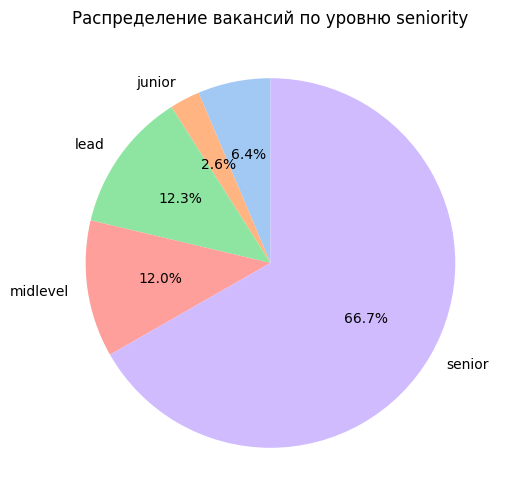

/content/job_module.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="seniority_level", y="avg_salary", data=df, palette="viridis")


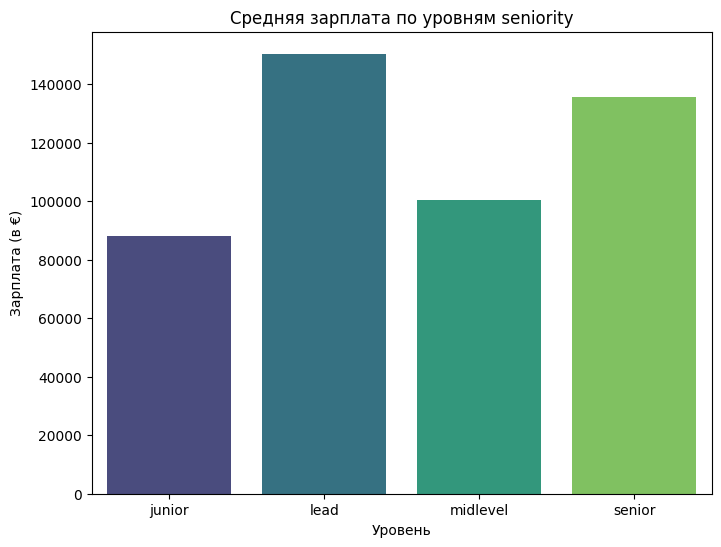

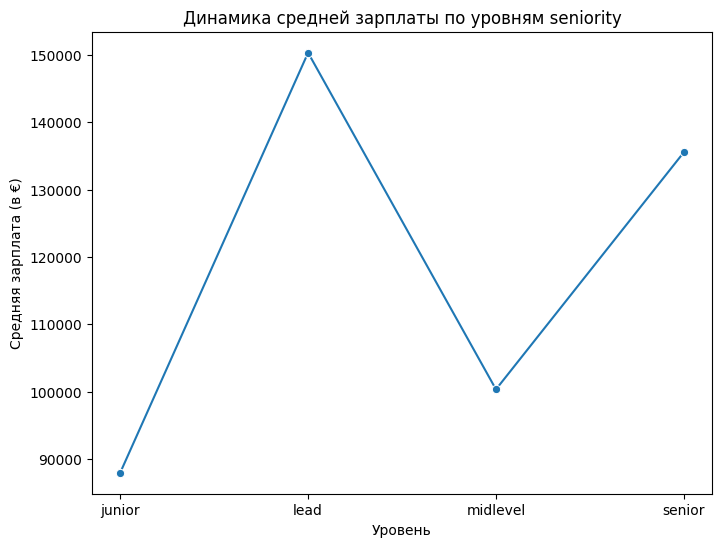

/content/job_module.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="location", data=df, palette="coolwarm")


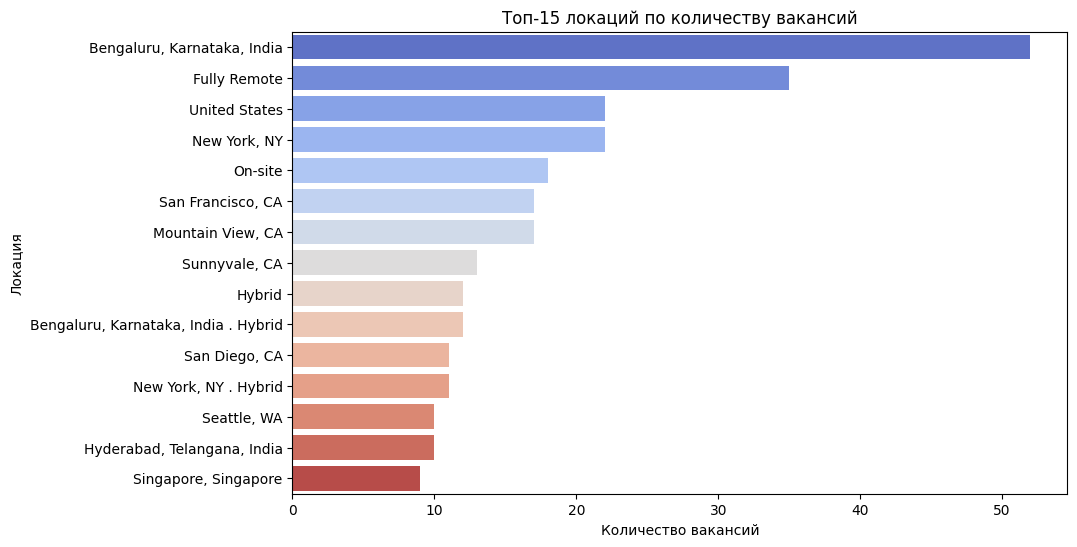

/content/job_module.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_salary", y="location", data=df, palette="magma")


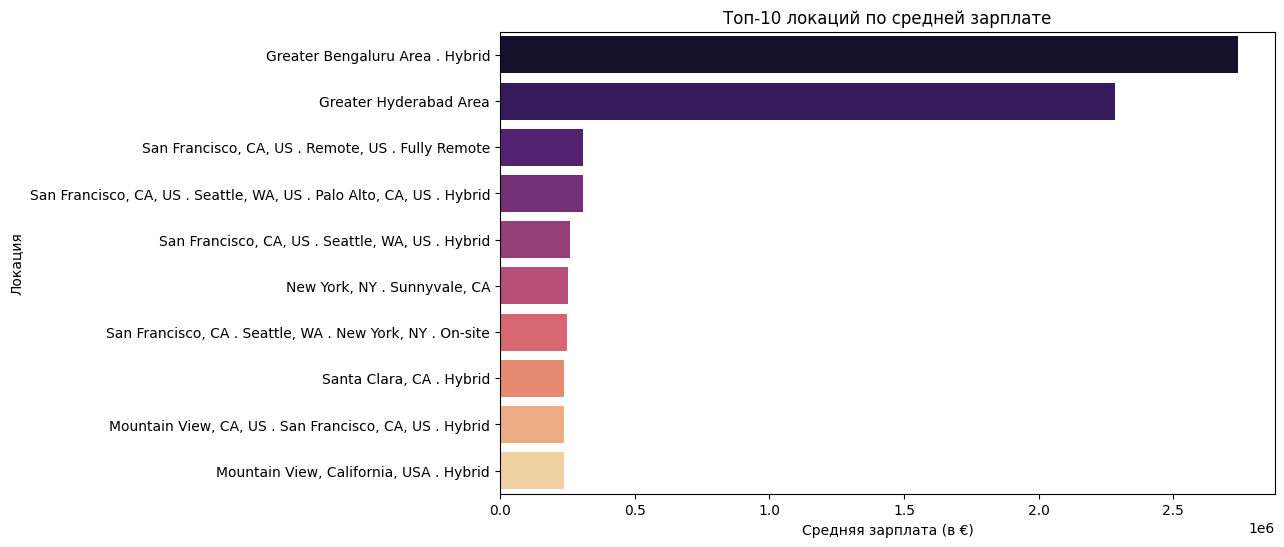

Разделение таблицы по уровню seniority:
--- Таблица для senior ---
                   job_title seniority_level   status      company  \
0             data scientist          senior   hybrid  company_003   
1             data scientist          senior  on-site  company_007   
2             data scientist          senior   hybrid  company_008   
3  machine learning engineer          senior  on-site  company_015   
4             data scientist          senior   remote  company_019   

                                            location    post_date  \
0                             Grapevine, TX . Hybrid  17 days ago   
1  Austin, TX . Toronto, Ontario, Canada . Kirkla...  a month ago   
2  Chicago, IL . Scottsdale, AZ . Austin, TX . Hy...   8 days ago   
3                                     Menlo Park, CA   9 days ago   
4                                       Fully Remote   6 days ago   

            headquarter    industry ownership company_size  revenue  \
0   Bentonville, AR, US   

In [43]:
importlib.reload(job_module)
from job_module import *

def main():
    file_path = "/kaggle/input/data-science-job-postings-with-salaries-2025/data_science_job_posts_2025.csv"
    db_name = "jobs.db"

    try:
        print("Загрузка данных...")
        df = load_data(file_path)

        print("Предобработка...")
        df = preprocess_data(df)

        print("Создание базы данных...")
        conn = create_database(db_name, df)

        print("SQL-запросы в файл job_output.txt...")
        run_sql_queries(conn)

        print("Структура таблицы:")
        db_structure(conn)

        print("Визуализация распределений и зависимостей:")
        visualize_seniority_distribution_sql(conn)
        visualize_salary_by_seniority_sql(conn)
        visualize_salary_dynamics_sql(conn)
        visualize_count_location_sql(conn, top_n=15)
        visualize_salary_by_location_top_sql(conn, top_n=10)

        print("Разделение таблицы по уровню seniority:")
        tables = split_table_by_column_sql(conn, "seniority_level")
        for level, table in tables.items():
            print(f"--- Таблица для {level} ---")
            print(table.head())

        conn.close()
        print("\Работа завершена успешно ")

    except Exception as e:
        print(f"[ОШИБКА] {e}")
if __name__ == "__main__":
    main()


